In [43]:
# LEARNING GOALS
#
#                 - text as a datasource
#                 - cleaning text
#                 - basic eda
#                 - Doc Term Matrix representation by hand
#                 - The intuition behind working with text before jumping into tools that abstract this away
#                 - how text can be used in ML


In [44]:
# some helpful resources:
# https://www.w3schools.com/python/python_regex.asp
# https://docs.python.org/3/library/re.html
# https://www.debuggex.com/cheatsheet/regex/python
# https://www.shortcutfoo.com/app/dojos/python-regex/cheatsheet

In [45]:
# installs
! pip install newspaper3k
! pip install -U spacy
! pip install wordcloud
! pip install emoji
! pip install nltk
! pip install scikit-plot

In [46]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplot

# some "fun" new packages
from wordcloud import WordCloud
import emoji

import re

# new imports for text specific tasks
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer  
import nltk


In [71]:
PROJECT = 'ba820-avs'   
SQL = "SELECT * from `questrom.SMSspam.train`"
SMSspam_train = pd.read_gbq(SQL, PROJECT)

In [72]:
SQL = "SELECT * from `questrom.SMSspam.test`"
SMSspam_test = pd.read_gbq(SQL, PROJECT)

In [73]:
SMSspam_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3835.0,2131.919166,1228.935817,1.0,1070.5,2125.0,3196.5,4262.0


In [75]:
SMSspam_train.head()

,message,label,id
0,"Go until jurong point, crazy.. Available only ...",ham,1
1,Ok lar... Joking wif u oni...,ham,2
2,U dun say so early hor... U c already then say...,ham,3
3,I HAVE A DATE ON SUNDAY WITH WILL!!,ham,9
4,Fine if that’s the way u feel. That’s the way ...,ham,12


In [76]:
SMSspam_train.set_index("id", inplace=True)
SMSspam_train.head()

,message,label
id,,
1,"Go until jurong point, crazy.. Available only ...",ham
2,Ok lar... Joking wif u oni...,ham
3,U dun say so early hor... U c already then say...,ham
9,I HAVE A DATE ON SUNDAY WITH WILL!!,ham
12,Fine if that’s the way u feel. That’s the way ...,ham


In [77]:
# tokenize
cv = CountVectorizer()

SMStokens = cv.fit_transform(SMSspam_train['message'])
SMStokens

<3835x6875 sparse matrix of type '<class 'numpy.int64'>'
	with 47282 stored elements in Compressed Sparse Row format>

In [78]:
cv.vocabulary_

{'go': 2852,
 'until': 6364,
 'jurong': 3491,
 'point': 4724,
 'crazy': 1884,
 'available': 1085,
 'only': 4421,
 'in': 3287,
 'bugis': 1441,
 'great': 2919,
 'world': 6744,
 'la': 3589,
 'buffet': 1440,
 'cine': 1678,
 'there': 6054,
 'got': 2890,
 'amore': 907,
 'wat': 6554,
 'ok': 4394,
 'lar': 3613,
 'joking': 3463,
 'wif': 6663,
 'oni': 4417,
 'dun': 2260,
 'say': 5264,
 'so': 5582,
 'early': 2276,
 'hor': 3155,
 'already': 887,
 'then': 6049,
 'have': 3028,
 'date': 1979,
 'on': 4411,
 'sunday': 5847,
 'with': 6698,
 'will': 6670,
 'fine': 2588,
 'if': 3251,
 'that': 6033,
 'the': 6036,
 'way': 6567,
 'feel': 2539,
 'its': 3395,
 'gota': 2891,
 'is': 3377,
 'seriously': 5359,
 'how': 3175,
 'you': 6844,
 'spell': 5659,
 'his': 3105,
 'name': 4202,
 'going': 2863,
 'to': 6139,
 'try': 6250,
 'for': 2657,
 'months': 4109,
 'ha': 2965,
 'pay': 4569,
 'first': 2600,
 'when': 6637,
 'da': 1955,
 'stock': 5756,
 'comin': 1758,
 'aft': 821,
 'finish': 2591,
 'my': 4186,
 'lunch': 3825,


In [79]:
len(cv.vocabulary_)


6875

In [80]:
# confirm the shape is what we expect
print(SMStokens.shape)
print(SMSspam_train.shape)

(3835, 6875)
(3835, 2)


In [81]:
# make this a dataframe to help with our mental model
SMStokens_df = pd.DataFrame(SMStokens.toarray(), columns=cv.get_feature_names())
SMStokens_df.columns

Index(['00', '000', '000pes', '008704050406', '0089', '0121', '01223585334',
       '0125698789', '02', '0207',
       ...
       'zealand', 'zed', 'zindgi', 'zoe', 'zogtorius', 'zouk', 'zyada', 'èn',
       'ú1', '〨ud'],
      dtype='object', length=6875)

In [82]:
# lets build the datasets for the model

X = SMStokens_df.copy()
y = SMSspam_train.label

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [84]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=820, stratify=y)

In [85]:
# fit the model

tree = DecisionTreeClassifier(max_depth=5, min_samples_split=30, min_samples_leaf=15)
tree.fit(X_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [86]:
# fit metrics on test
preds = tree.predict(X_test)
ctable = metrics.classification_report(y_test, preds)
print(ctable)


              precision    recall  f1-score   support

         ham       0.97      0.97      0.97       974
        spam       0.84      0.82      0.83       177

    accuracy                           0.95      1151
   macro avg       0.90      0.90      0.90      1151
weighted avg       0.95      0.95      0.95      1151



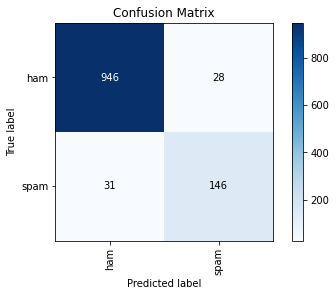

0.94874022589053

In [87]:
# confusion matrix from skplot
# cancan see where the model isn't sure

skplot.metrics.plot_confusion_matrix(y_test, preds, 
                                     figsize=(7,4), 
                                     x_tick_rotation=90 )
plt.show()

# accuracy score   <----- confirming the classification report
tree.score(X_test, y_test)

In [88]:
# tokenize

SMStokens_test = cv.transform(SMSspam_test['message'])
SMStokens_test


<427x6875 sparse matrix of type '<class 'numpy.int64'>'
	with 4912 stored elements in Compressed Sparse Row format>

In [90]:
# make this a dataframe to help with our mental model
SMStokens_test_df = pd.DataFrame(SMStokens_test.toarray(), columns=cv.get_feature_names())
SMStokens_test_df.columns

Index(['00', '000', '000pes', '008704050406', '0089', '0121', '01223585334',
       '0125698789', '02', '0207',
       ...
       'zealand', 'zed', 'zindgi', 'zoe', 'zogtorius', 'zouk', 'zyada', 'èn',
       'ú1', '〨ud'],
      dtype='object', length=6875)

In [93]:
# lets build the datasets for the model
X = SMStokens_test_df.copy()

In [96]:
# fit metrics on test
preds_test = tree.predict(X)

In [97]:
len(preds_test)

427

In [110]:
SMSspam_test['label'] = preds_test

In [111]:
SMSspam_test.head()

,id,test_label,label
0,4,ham,ham
1,5,spam,spam
2,11,ham,ham
3,19,ham,ham
4,21,ham,ham


In [113]:
del SMSspam_test['test_label']

In [114]:
SMSspam_test.head()

,id,label
0,4,ham
1,5,spam
2,11,ham
3,19,ham
4,21,ham


In [115]:
SMSspam_test.set_index('id', inplace=True)

In [116]:
SMSspam_test.reset_index(inplace=True)

In [117]:
SMSspam_test.head()

,id,label
0,4,ham
1,5,spam
2,11,ham
3,19,ham
4,21,ham


In [118]:
SMSspam_test.to_csv('competition.csv')